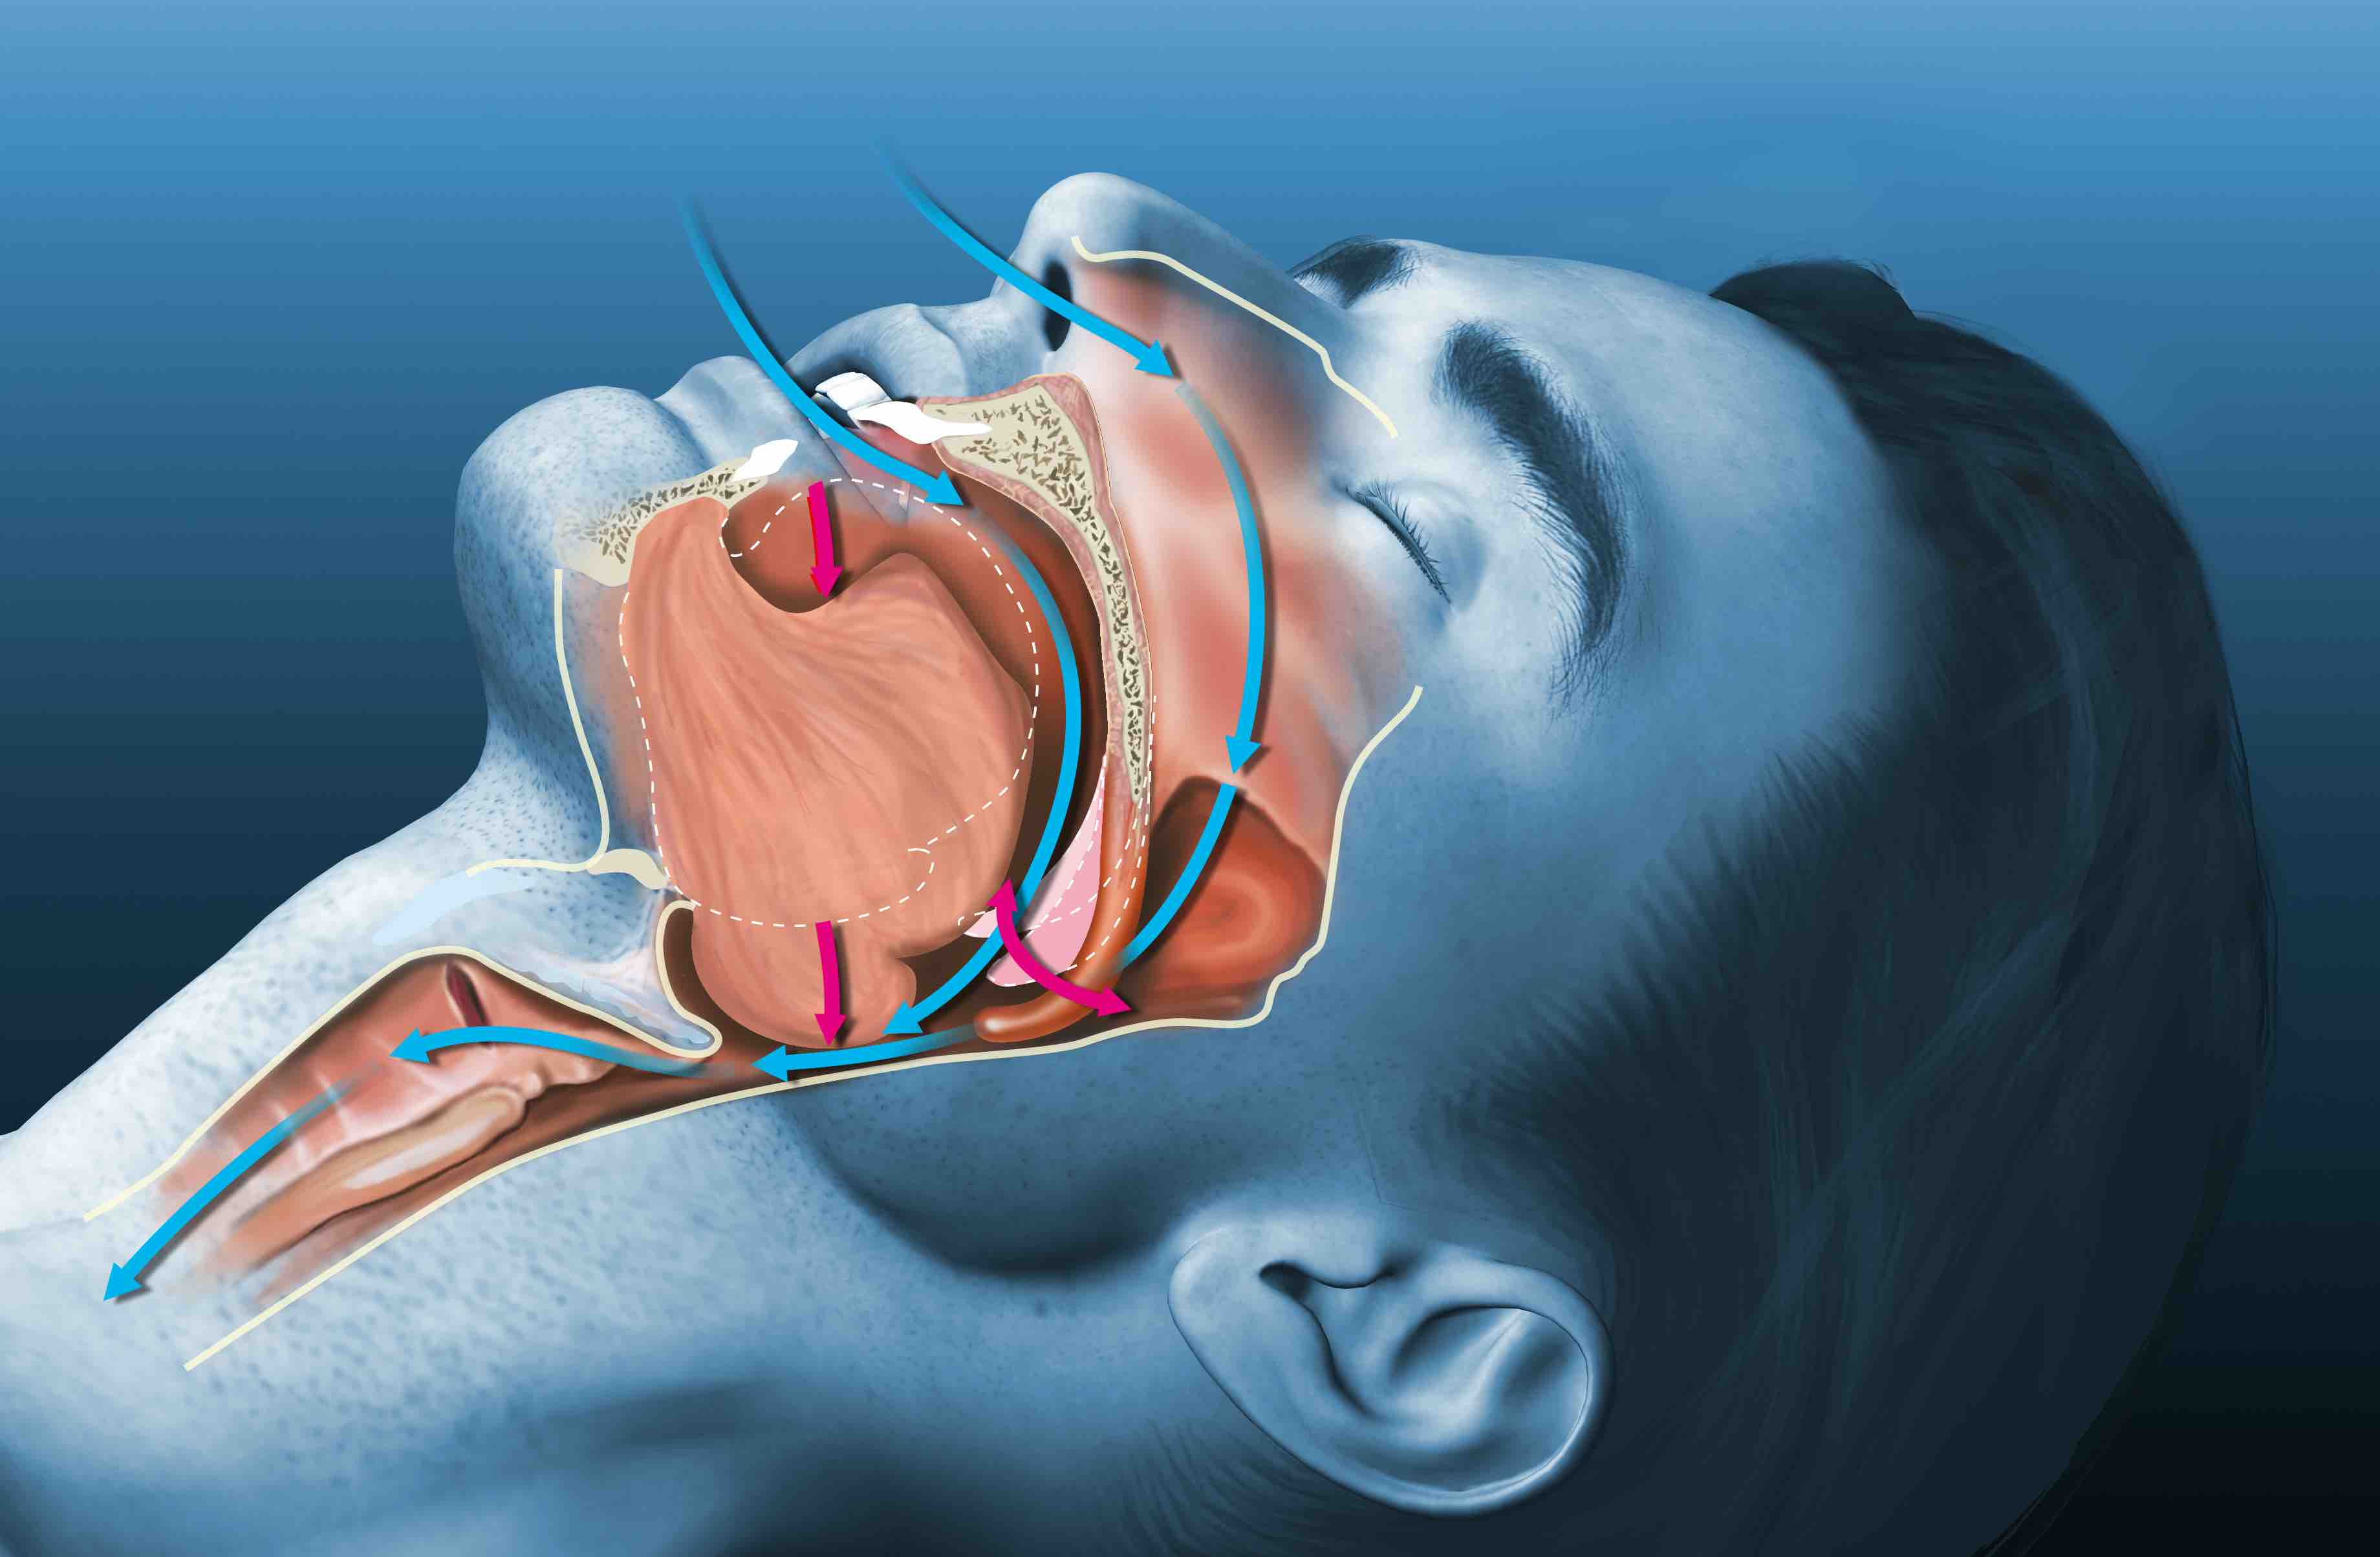
# About
## Overview
Respiratory rates are vital indicators of health used by clinicians in various healthcare settings. They provide valuable insights into the respiratory system's functioning and help diagnose potential abnormalities. However, manual measurement of respiratory rates is time-consuming and prone to inaccuracies. To overcome these limitations, we aim to develop a machine learning-based method for predicting respiratory rates using physiological signals such as ECG, PPG, and impedance pneumography. By leveraging advanced algorithms, we can estimate respiratory rates accurately and in real time, enabling continuous monitoring and early detection of respiratory irregularities.

The ability to predict respiratory rates has significant implications for healthcare. It empowers healthcare providers to continuously monitor patients' respiratory status, even in situations where direct observation is challenging. By accurately forecasting respiratory rates, healthcare teams can promptly identify deviations from normal ranges and initiate appropriate interventions. This proactive approach can prevent adverse events, optimize patient care pathways, and improve outcomes. By harnessing the power of predictive analytics, we can revolutionize respiratory rate assessment, management, and patient care, ultimately enhancing the well-being and safety of individuals in healthcare settings.

##  Features

1. breaths ann1 [signal sample no]: Manual annotations of breaths by the first annotator, indicating the sample numbers corresponding to the start and end of each breath.

2. breaths ann2 [signal sample no]: Manual annotations of breaths by the second annotator, indicating the sample numbers corresponding to the start and end of each breath.

3. HR: Heart rate, derived from the ECG signal (beats per minute).

4. PULSE: Pulse rate, derived from the PPG signal (beats per minute).

5. RESP: Respiratory rate, derived from the impedance respiratory signal (breaths per minute).

6. SpO2: Blood oxygen saturation level, expressed as a percentage.

7. RESP: Impedance respiratory signal.

8. PLETH: Photoplethysmogram (PPG) signal.

9. V: Lead V ECG signal.

10. AVR: Lead AVR ECG signal.

11. II: Lead II ECG signal.

These features represent various physiological parameters and signals recorded during the monitoring of critically-ill patients. They provide valuable information for assessing cardiac and respiratory function.

# Data Analysis

## Data Exploration and Cleaning

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and connected.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU instead.")

print("Device:", device)


GPU is available and connected.
Device: cuda


#### Loading the dataframes, renaming them ; renaming and dropping colmns where necessary

In [ ]:
#libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import signal
!pip install biosppy
from biosppy.signals import ecg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 1.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/bidmc_csv')
directory = '/content/drive/MyDrive/bidmc_csv'



Mounted at /content/drive


In [ ]:
dfs = []
df_names = []

for file_name in os.listdir(directory):
    if file_name.endswith('.csv'):
        # Extract the person number from the file name
        person_number = file_name.split('_')[1][:2]

        df = pd.read_csv(os.path.join(directory, file_name))

        # Rename the dataframe
        df_name = f"{person_number}_{'_'.join(file_name.split('_')[2:])[:-4]}"

        df.name = df_name
        dfs.append(df)
        df_names.append(df_name)

for i, df in enumerate(dfs):
    print(f"Dataframe {df_names[i]}:")
    print(df.head())
    print()


Dataframe 15_Breaths:
   breaths ann1 [signal sample no]   breaths ann2 [signal sample no]
0                            620.0                               251
1                           1154.0                               599
2                           1533.0                              1148
3                           2067.0                              1522
4                           2607.0                              2050

Dataframe 15_Numerics:
   Time [s]   HR   PULSE   RESP   SpO2
0         0  109     109   11.0     99
1         1  109     109   11.0     99
2         2  109     109   11.0     99
3         3  109     109   11.0     99
4         4  109     109   11.0     99

Dataframe 37_Numerics:
   Time [s]   HR   PULSE   RESP   SpO2
0         0   90      89     20    100
1         1   90      89     20    100
2         2   90      89     20    100
3         3   90      89     19    100
4         4   90      89     19    100

Dataframe 01_Signals:
   Time [s]     RESP    P

In [ ]:

# Rename columns and assign names to dataframes
for i, df in enumerate(dfs):
    df.rename(columns={'Time [s]': 'Time_S',
                       'breaths ann1 [signal sample no]': 'breathsAnn1',
                       ' breaths ann2 [signal sample no]': 'breathsAnn2'}, inplace=True)



In [ ]:
# Rename '40_Numerics' dataframe to '40_Breaths'
for i, df in enumerate(dfs):
    if df_names[i].startswith('40_Numerics'):
        df_name = df_names[i].replace('40_Numerics', '40_Breaths')
        dfs[i].name = df_name
        break

# Find and display the '40_Breaths' dataframe
df_40_breaths = None
for i, df in enumerate(dfs):
    if '40_Breaths' in df_names[i]:
        df_40_breaths = df
        break

if df_40_breaths is not None:
    print(df_40_breaths)
else:
    print("40_Breaths dataframe not found.")



     breathsAnn1  breathsAnn2
0           89.0           66
1          602.0          615
2         1085.0         1079
3         1576.0         1554
4         2115.0         2108
..           ...          ...
127          NaN        57862
128          NaN        58416
129          NaN        58902
130          NaN        59440
131          NaN        59957

[132 rows x 2 columns]


In [ ]:
for df, df_name in zip(dfs, df_names):
    if 'Numerics' in df_name:
        # Drop the 'RESP' column from the dataframe since the RESP in signals is more relevant to keep
        df.drop(columns=[col for col in df.columns if col.lower() == ' resp'], inplace=True)

for df, df_name in zip(dfs, df_names):
    print(f"{df_name}")
    print(df.head())
    print()


15_Breaths
   breathsAnn1  breathsAnn2
0        620.0          251
1       1154.0          599
2       1533.0         1148
3       2067.0         1522
4       2607.0         2050

15_Numerics
   Time_S   HR   PULSE   SpO2
0       0  109     109     99
1       1  109     109     99
2       2  109     109     99
3       3  109     109     99
4       4  109     109     99

37_Numerics
   Time_S   HR   PULSE   SpO2
0       0   90      89    100
1       1   90      89    100
2       2   90      89    100
3       3   90      89    100
4       4   90      89    100

01_Signals
   Time_S     RESP    PLETH        V      AVR       II
0   0.000  0.35386  0.43597  0.52549  0.30392  0.72549
1   0.008  0.35679  0.43206  0.51961  0.33529  0.67059
2   0.016  0.35875  0.42815  0.51569  0.37451  0.60980
3   0.024  0.36168  0.42424  0.50588  0.41961  0.55098
4   0.032  0.36364  0.42131  0.50980  0.44902  0.50000

33_Breaths
   breathsAnn1  breathsAnn2
0          102         98.0
1          620        631



```
# Ce texte est au format code
```

### Handling missing values and outliers

In [ ]:
numerics_dfs = []
breaths_dfs = []
signals_dfs = []

for df, df_name in zip(dfs, df_names):
    if 'Numerics' in df_name:
        numerics_dfs.append(df)
    elif 'Breaths' in df_name:
        breaths_dfs.append(df)
    elif 'Signals' in df_name:
        signals_dfs.append(df)

merged_numerics = pd.concat(numerics_dfs, ignore_index=True)
merged_breaths = pd.concat(breaths_dfs, ignore_index=True)
merged_signals = pd.concat(signals_dfs, ignore_index=True)

print("Merged Numerics:")
print(merged_numerics.head())
print()

print("Merged Breaths:")
print(merged_breaths.head())
print()

print("Merged Signals:")
print(merged_signals.head())
print()


Merged Numerics:
   Time_S     HR   PULSE   SpO2
0       0  109.0   109.0   99.0
1       1  109.0   109.0   99.0
2       2  109.0   109.0   99.0
3       3  109.0   109.0   99.0
4       4  109.0   109.0   99.0

Merged Breaths:
   breathsAnn1  breathsAnn2
0        620.0        251.0
1       1154.0        599.0
2       1533.0       1148.0
3       2067.0       1522.0
4       2607.0       2050.0

Merged Signals:
   Time_S     RESP    PLETH        V      AVR       II   MCL   I   ABP   CVP  \
0   0.000  0.35386  0.43597  0.52549  0.30392  0.72549   NaN NaN   NaN   NaN   
1   0.008  0.35679  0.43206  0.51961  0.33529  0.67059   NaN NaN   NaN   NaN   
2   0.016  0.35875  0.42815  0.51569  0.37451  0.60980   NaN NaN   NaN   NaN   
3   0.024  0.36168  0.42424  0.50588  0.41961  0.55098   NaN NaN   NaN   NaN   
4   0.032  0.36364  0.42131  0.50980  0.44902  0.50000   NaN NaN   NaN   NaN   

    ART   III  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   NaN   NaN  



In [ ]:
total_rows_numerics = len(merged_numerics)
total_rows_breaths = len(merged_breaths)
total_rows_signals = len(merged_signals)

nan_counts_numerics = merged_numerics.isna().sum()
nan_counts_breaths = merged_breaths.isna().sum()
nan_counts_signals = merged_signals.isna().sum()

## Calculate the percentage of NaN values in each DataFrame

nan_percentages_numerics = nan_counts_numerics / total_rows_numerics * 100
nan_percentages_breaths = nan_counts_breaths / total_rows_breaths * 100
nan_percentages_signals = nan_counts_signals / total_rows_signals * 100

print("Percentage of NaN values in Merged Numerics:")
for column, percentage in nan_percentages_numerics.items():
    print(column, ": ", percentage)

print("\nPercentage of NaN values in Merged Breaths:")
for column, percentage in nan_percentages_breaths.items():
    print(column, ": ", percentage)

print("\nPercentage of NaN values in Merged Signals:")
for column, percentage in nan_percentages_signals.items():
    print(column, ": ", percentage)


Percentage of NaN values in Merged Numerics:
Time_S :  0.0
 HR :  0.01569058172831758
 PULSE :  0.5020986153061625
 SpO2 :  0.5020986153061625

Percentage of NaN values in Merged Breaths:
breathsAnn1 :  1.446923597025017
breathsAnn2 :  0.18931710615280595

Percentage of NaN values in Merged Signals:
Time_S :  0.0
 RESP :  0.0
 PLETH :  0.0
 V :  7.547169811320755
 AVR :  11.320754716981133
 II :  0.0
 MCL :  92.45283018867924
 I :  90.56603773584906
 ABP :  84.90566037735849
 CVP :  81.13207547169812
 ART :  96.22641509433963
 III :  98.11320754716981


Dropping columns with NaN percentage higher than 80 % as these columns contain a significant amount of missing values, indicating that the data in those columns may be unreliable or irrelevant for the analysis

In [ ]:
column_list = [' I', ' III', ' MCL', ' ABP', ' CVP', ' ART']

for i, df in enumerate(dfs):
    existing_columns = [col for col in column_list if col in df.columns]
    if existing_columns:
        dfs[i] = df.drop(existing_columns, axis=1)
        print(f"{df.name} (after dropping specified columns):")
        print(dfs[i].head())
    else:
        print("Dataframe does not have the specified columns.")
    print()


Dataframe does not have the specified columns.

Dataframe does not have the specified columns.

Dataframe does not have the specified columns.

Dataframe does not have the specified columns.

Dataframe does not have the specified columns.

Dataframe does not have the specified columns.

49_Signals (after dropping specified columns):
   Time_S     RESP    PLETH       II      AVR
0   0.000  0.66178  0.30401  0.39412  0.58984
1   0.008  0.66276  0.29912  0.39020  0.59961
2   0.016  0.66471  0.29619  0.39412  0.59570
3   0.024  0.66471  0.29326  0.40392  0.58398
4   0.032  0.66569  0.29130  0.41569  0.57422

Dataframe does not have the specified columns.

Dataframe does not have the specified columns.

Dataframe does not have the specified columns.

38_Signals (after dropping specified columns):
   Time_S     RESP    PLETH       II
0   0.000  0.84946  0.45943  0.10392
1   0.008  0.82991  0.45259  0.10392
2   0.016  0.81036  0.44673  0.10392
3   0.024  0.79081  0.44086  0.10392
4   0.032  0

Filling the missing values with Mean/ Time-based interpolate

> Bloc en retrait



In [ ]:
# Apply mean fill on breaths datasets
for df_name, df in zip(df_names, dfs):
    if 'Breaths' in df_name:
        if df.isnull().values.any():
            df.fillna(df.mean(), inplace=True)

# Apply time-based interpolation on numerics, signals, and breaths
for df_name, df in zip(df_names, dfs):
    if 'Numerics' in df_name or 'Signals' in df_name:
        if df.isnull().values.any():
            if 'Time_S' in df.columns:
                df['Time_S'] = pd.to_datetime(df['Time_S'], unit='s')
                df.set_index('Time_S', inplace=True)
                df.interpolate(method='time', inplace=True)
                df.reset_index(inplace=True)
            else:
                print(f"DataFrame {df_name} does not have a 'Time_S' column.")
    elif 'Breaths' not in df_name:
        print(f"Invalid element in dfs: {df_name}")


In [ ]:
# Count NaN values in each dataframe
for df_name, df in zip(df_names, dfs):
    nan_count = df.isnull().sum().sum()
    print(f"NaN count in {df_name}: {nan_count}")


NaN count in 15_Breaths: 0
NaN count in 15_Numerics: 0
NaN count in 37_Numerics: 0
NaN count in 01_Signals: 0
NaN count in 33_Breaths: 0
NaN count in 06_Breaths: 0
NaN count in 49_Signals: 0
NaN count in 28_Numerics: 0
NaN count in 52_Breaths: 0
NaN count in 05_Breaths: 0
NaN count in 38_Signals: 0
NaN count in 48_Signals: 0
NaN count in 41_Breaths: 0
NaN count in 22_Breaths: 0
NaN count in 30_Breaths: 0
NaN count in 07_Numerics: 0
NaN count in 36_Breaths: 0
NaN count in 20_Numerics: 0
NaN count in 32_Numerics: 0
NaN count in 31_Numerics: 0
NaN count in 14_Breaths: 0
NaN count in 33_Numerics: 0
NaN count in 34_Breaths: 0
NaN count in 52_Numerics: 0
NaN count in 12_Signals: 0
NaN count in 02_Breaths: 0
NaN count in 47_Numerics: 0
NaN count in 41_Numerics: 0
NaN count in 34_Signals: 0
NaN count in 30_Signals: 0
NaN count in 43_Numerics: 0
NaN count in 35_Numerics: 0
NaN count in 22_Signals: 0
NaN count in 07_Signals: 0
NaN count in 11_Numerics: 0
NaN count in 09_Numerics: 0
NaN count in 

In [ ]:
for i, df_name in enumerate(df_names):
    if df_name in ['25_Numerics', '19_Numerics']:
        df = dfs[i]

        df = df.fillna(df.mean())  # Fill missing values with mean values

        dfs[i] = df  # Update the DataFrame in the original list

        print(f"DataFrame {df_name}:")
        print(df.head())
        print()


DataFrame 25_Numerics:
               Time_S   HR       PULSE      SpO2
0 1970-01-01 00:00:00  126  124.747917  97.58125
1 1970-01-01 00:00:01  126  127.000000  99.00000
2 1970-01-01 00:00:02  123  126.000000  99.00000
3 1970-01-01 00:00:03  126  126.000000  99.00000
4 1970-01-01 00:00:04  126  125.000000  99.00000

DataFrame 19_Numerics:
               Time_S   HR      PULSE   SpO2
0 1970-01-01 00:00:00   74  72.883966  100.0
1 1970-01-01 00:00:01   73  72.883966  100.0
2 1970-01-01 00:00:02   73  72.883966  100.0
3 1970-01-01 00:00:03   72  72.883966  100.0
4 1970-01-01 00:00:04   72  72.883966  100.0



<ipython-input-14-e6db6ebb7bf1>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df = df.fillna(df.mean())  # Fill missing values with mean values
<ipython-input-14-e6db6ebb7bf1>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df = df.fillna(df.mean())  # Fill missing values with mean values


In [ ]:
for i, df_name in enumerate(df_names):
    if df_name in ['25_Numerics', '19_Numerics']:
          nan_count = df.isnull().sum().sum()
          print(f"NaN count in {df_name}: {nan_count}")



NaN count in 25_Numerics: 0
NaN count in 19_Numerics: 0


### Outlier handling

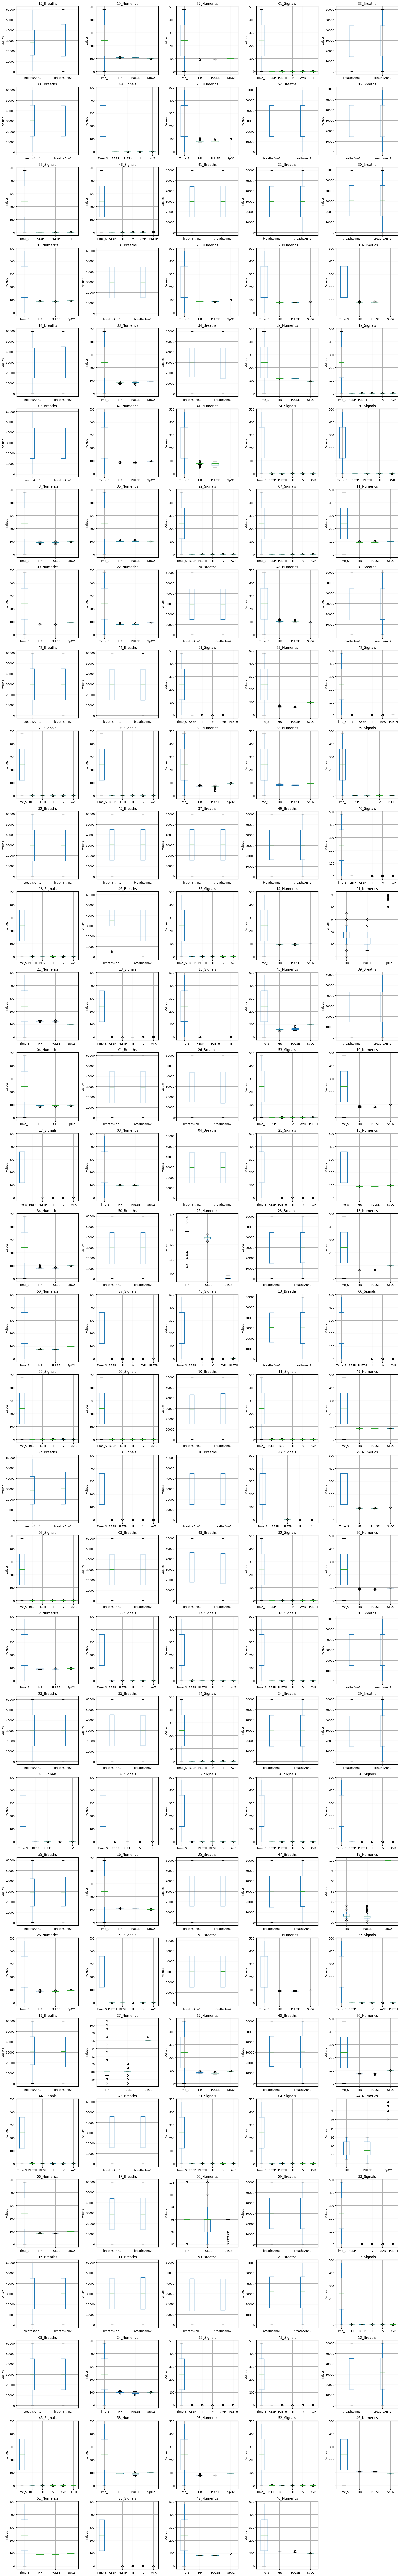

In [ ]:
import matplotlib.pyplot as plt

num_dataframes = len(dfs)
num_rows = (num_dataframes // 5) + 1
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows*4))

for i, (df, df_name) in enumerate(zip(dfs, df_names)):
    row_idx = i // num_cols
    col_idx = i % num_cols

    ax = axes[row_idx, col_idx]
    df.boxplot(ax=ax)

    ax.set_title(df_name)
    ax.set_ylabel('Values')

if num_dataframes < num_rows * num_cols:
    for i in range(num_dataframes, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()



As for the range of values in the medical field for these variables, here are some general ranges. Note that these ranges can vary based on individual health, disease state, and other factors:

- Heart Rate (HR): Normal range is typically 60-100 beats per minute for adults. However, athletes can have resting heart rates below 60, and during intense physical activity, the heart rate can exceed 200 beats per minute. In certain medical conditions, the heart rate can also exceed the normal range.
  
- Pulse Rate (PULSE): Should be the same as the heart rate if the heart's contractions are strong enough to propagate to the peripheral arteries.

- Respiratory Rate (RESP): A normal respiratory rate for healthy adults is 12 to 20 breaths per minute. For critically ill patients, this can be higher.

- Blood Oxygen Saturation Level (SpO2): Normal levels should be at 95-100%. Levels below 90% are considered low. For some individuals with specific conditions, the normal range may be lower.

- Impedance Respiratory Signal (RESP): This is a method of estimating respiratory rate and other respiratory-related metrics. There's no defined "normal" range for this, as it's a relative measure and not directly indicative of a specific physiological state.

- Photoplethysmogram Signal (PLETH): This signal is used to measure relative blood flow changes, and therefore does not have a 'normal' range.

- Lead V ECG Signal (V), Lead AVR ECG Signal (AVR), and Lead II ECG Signal (II): ECG signals represent electrical activity of the heart, and do not have specific 'ranges' in the conventional sense. They are interpreted based on their pattern and characteristics, not amplitude.



In [ ]:
# Define the standard medical ranges for each relevant variable
medical_ranges = {
    ' HR': (20, 200),
    ' PULSE': (20, 200),
    ' SpO2': (70, 100),
    ' RESP': (-1, 1),
    ' PLETH': (-1, 1),
    ' V': (-1, 1),
    ' AVR': (-1, 1),
    ' II': (-1, 1),
}

def check_ranges(df, medical_ranges):
    for column in df.columns:
        if column in medical_ranges:
            min_value = df[column].min()
            max_value = df[column].max()
            if min_value < medical_ranges[column][0]:
                print(f"Column '{column}' has a minimum value of {min_value}, which is less than the expected minimum of {medical_ranges[column][0]}.")
            if max_value > medical_ranges[column][1]:
                print(f"Column '{column}' has a maximum value of {max_value}, which is greater than the expected maximum of {medical_ranges[column][1]}.")

# Iterate over your list of DataFrames and their names
for df, df_name in zip(dfs, df_names):
    print(f"Checking ranges for '{df_name}':")
    check_ranges(df, medical_ranges)
    print()


Checking ranges for '15_Breaths':

Checking ranges for '15_Numerics':

Checking ranges for '37_Numerics':

Checking ranges for '01_Signals':
Column ' V' has a maximum value of 1.5039, which is greater than the expected maximum of 1.
Column ' AVR' has a maximum value of 1.0471, which is greater than the expected maximum of 1.
Column ' II' has a maximum value of 1.5039, which is greater than the expected maximum of 1.

Checking ranges for '33_Breaths':

Checking ranges for '06_Breaths':

Checking ranges for '49_Signals':

Checking ranges for '28_Numerics':

Checking ranges for '52_Breaths':

Checking ranges for '05_Breaths':

Checking ranges for '38_Signals':

Checking ranges for '48_Signals':
Column ' II' has a maximum value of 1.5, which is greater than the expected maximum of 1.
Column ' V' has a maximum value of 1.5, which is greater than the expected maximum of 1.
Column ' AVR' has a maximum value of 1.501, which is greater than the expected maximum of 1.
Column ' PLETH' has a maxim

In [ ]:

def replace_out_of_range(df, medical_ranges):
    for column in df.columns:
        if column in medical_ranges:
            df[column] = df[column].clip(medical_ranges[column][0], medical_ranges[column][1])

# Iterate over your list of DataFrames and their names
for df, df_name in zip(dfs, df_names):
    replace_out_of_range(df, medical_ranges)


print(f"Replacing out-of-range values when necessary")
print()


Replacing out-of-range values when necessary



In [ ]:
def verify_ranges(df, medical_ranges):
    out_of_range_columns = []
    for column in df.columns:
        if column in medical_ranges:
            min_value = df[column].min()
            max_value = df[column].max()
            if min_value < medical_ranges[column][0] or max_value > medical_ranges[column][1]:
                out_of_range_columns.append(column)
    if out_of_range_columns:
        print(f"Columns with values out of range: {out_of_range_columns}")
    else:
        print("All columns are within the range.")

# Iterate over your list of DataFrames and their names
for df, df_name in zip(dfs, df_names):
    if 'Signals' in df_name or 'Numerics' in df_name:
        print(f"Verifying ranges for '{df_name}':")
        verify_ranges(df, medical_ranges)
        print()



Verifying ranges for '15_Numerics':
All columns are within the range.

Verifying ranges for '37_Numerics':
All columns are within the range.

Verifying ranges for '01_Signals':
All columns are within the range.

Verifying ranges for '49_Signals':
All columns are within the range.

Verifying ranges for '28_Numerics':
All columns are within the range.

Verifying ranges for '38_Signals':
All columns are within the range.

Verifying ranges for '48_Signals':
All columns are within the range.

Verifying ranges for '07_Numerics':
All columns are within the range.

Verifying ranges for '20_Numerics':
All columns are within the range.

Verifying ranges for '32_Numerics':
All columns are within the range.

Verifying ranges for '31_Numerics':
All columns are within the range.

Verifying ranges for '33_Numerics':
All columns are within the range.

Verifying ranges for '52_Numerics':
All columns are within the range.

Verifying ranges for '12_Signals':
All columns are within the range.

Verifying r

Merging the Signals and Numerics dataframes for each person to one dataframe

In [ ]:
for i, df_name in enumerate(df_names):
    if 'Signals' in df_name:
        df = dfs[i].copy()  # Retrieve a copy of the DataFrame from the original list
        df['Time_S'] = df['Time_S'].round()  # Round the 'Time_S' column
        dfs[i] = df  # Update the DataFrame in the original list

# Print the modified DataFrames
for df_name, df in zip(df_names, dfs):
    print(f"DataFrame {df_name}:")
    print(df.head())
    print()


DataFrame 15_Breaths:
   breathsAnn1  breathsAnn2
0        620.0          251
1       1154.0          599
2       1533.0         1148
3       2067.0         1522
4       2607.0         2050

DataFrame 15_Numerics:
   Time_S   HR   PULSE   SpO2
0       0  109     109     99
1       1  109     109     99
2       2  109     109     99
3       3  109     109     99
4       4  109     109     99

DataFrame 37_Numerics:
   Time_S   HR   PULSE   SpO2
0       0   90      89    100
1       1   90      89    100
2       2   90      89    100
3       3   90      89    100
4       4   90      89    100

DataFrame 01_Signals:
   Time_S     RESP    PLETH        V      AVR       II
0     0.0  0.35386  0.43597  0.52549  0.30392  0.72549
1     0.0  0.35679  0.43206  0.51961  0.33529  0.67059
2     0.0  0.35875  0.42815  0.51569  0.37451  0.60980
3     0.0  0.36168  0.42424  0.50588  0.41961  0.55098
4     0.0  0.36364  0.42131  0.50980  0.44902  0.50000

DataFrame 33_Breaths:
   breathsAnn1  breathsAnn

In [ ]:
import re
import pandas as pd

# Create a dictionary to map signals DataFrame numbers to their corresponding numerics DataFrame
num_to_numerics = {}
for df_name in df_names:
    if 'Numerics' in df_name:
        num = re.search(r'\d+', df_name).group()
        num_to_numerics[num] = df_name

merged_dfs = []
merged_df_names = []  # New list to store the merged dataset names

for df_name in df_names:
    if 'Signals' in df_name:
        signals_df = dfs[df_names.index(df_name)].copy()

        # Extract the number from the signals DataFrame file name using regular expressions
        num = re.search(r'\d+', df_name).group()

        # Find the corresponding numerics DataFrame based on the number from the dictionary
        numerics_df_name = num_to_numerics.get(num)

        if numerics_df_name is not None:
            numerics_df = dfs[df_names.index(numerics_df_name)].copy()

            # Convert the 'Time_S' column to integer data type in signals DataFrame
            signals_df['Time_S'] = signals_df['Time_S'].astype(int)

            # Convert the 'Time_S' column to the same data type as signals DataFrame in numerics DataFrame
            numerics_df['Time_S'] = numerics_df['Time_S'].astype(int)

            merged_df = pd.merge(signals_df, numerics_df, on='Time_S', how='outer')
            merged_dfs.append(merged_df)

            # Create the new name for the merged dataset
            person_df_name = num + '_Person'
            merged_df_names.append(person_df_name)
        else:
            print(f"No matching numerics DataFrame found for {df_name}")

# Print the merged DataFrames with the new names
for merged_df_name, merged_df in zip(merged_df_names, merged_dfs):
    print(f"Merged DataFrame {merged_df_name}:")
    print(merged_df.head())
    print()


Merged DataFrame 01_Person:
   Time_S     RESP    PLETH        V      AVR       II    HR   PULSE   SpO2
0       0  0.35386  0.43597  0.52549  0.30392  0.72549  94.0    93.0   97.0
1       0  0.35679  0.43206  0.51961  0.33529  0.67059  94.0    93.0   97.0
2       0  0.35875  0.42815  0.51569  0.37451  0.60980  94.0    93.0   97.0
3       0  0.36168  0.42424  0.50588  0.41961  0.55098  94.0    93.0   97.0
4       0  0.36364  0.42131  0.50980  0.44902  0.50000  94.0    93.0   97.0

Merged DataFrame 49_Person:
   Time_S     RESP    PLETH       II      AVR   HR   PULSE   SpO2
0       0  0.66178  0.30401  0.39412  0.58984   84      85     86
1       0  0.66276  0.29912  0.39020  0.59961   84      85     86
2       0  0.66471  0.29619  0.39412  0.59570   84      85     86
3       0  0.66471  0.29326  0.40392  0.58398   84      85     86
4       0  0.66569  0.29130  0.41569  0.57422   84      85     86

Merged DataFrame 38_Person:
   Time_S     RESP    PLETH       II   HR   PULSE   SpO2
0    

In [ ]:
num_merged_dfs = len(merged_dfs)
print(f"Number of merged DataFrames: {num_merged_dfs}")


Number of merged DataFrames: 53


## Data Visualization

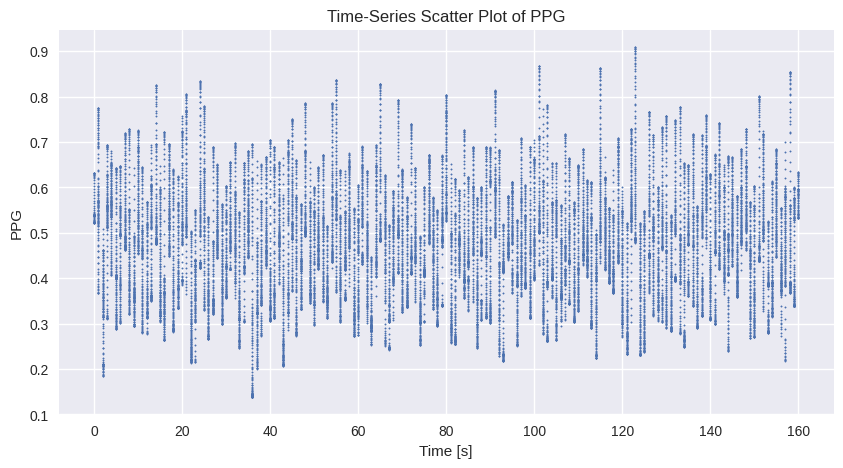

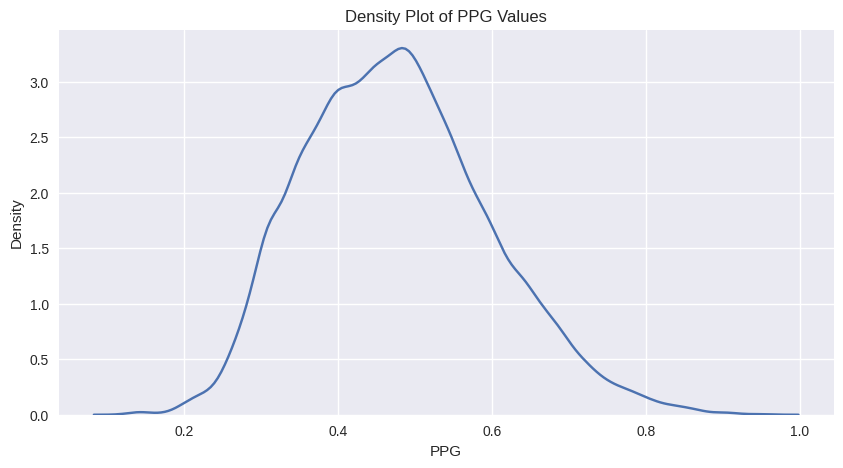

In [ ]:
  plt.figure(figsize=(10, 5))
  plt.scatter(person_df['Time_S'].loc[:20000], person_df[' PLETH'].loc[:20000], s=1)
  plt.xlabel('Time [s]')
  plt.ylabel('PPG')
  plt.title('Time-Series Scatter Plot of PPG')
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(10, 5))
  sns.kdeplot(person_df[' PLETH'].loc[:2000000])
  plt.xlabel('PPG')
  plt.ylabel('Density')
  plt.title('Density Plot of PPG Values')
  plt.grid(True)
  plt.show()


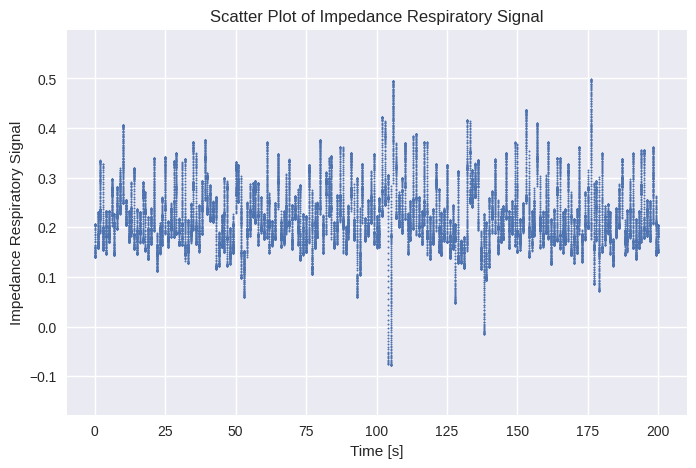

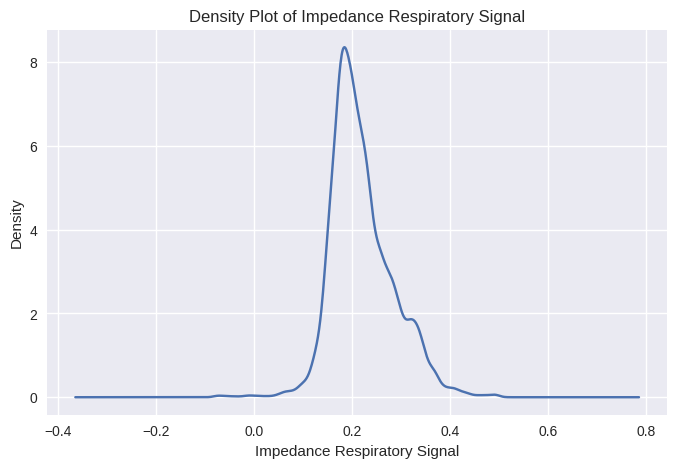

In [ ]:
# Select the 50th person's dataframe
person_df = merged_dfs[48]

# Set the figure size
plt.figure(figsize=(8, 5))
plt.scatter(person_df['Time_S'].loc[:25000], person_df[' RESP'].loc[:25000], s=1)
plt.xlabel('Time [s]')
plt.ylabel('Impedance Respiratory Signal')
plt.title(f'Scatter Plot of Impedance Respiratory Signal' )
plt.ylim(bottom=person_df[' RESP'].loc[:25000].min() - 0.1, top=person_df[' RESP'].loc[:25000].max() + 0.1)
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 5))
person_df[' RESP'].loc[:25000].plot(kind='density')
plt.xlabel('Impedance Respiratory Signal')
plt.title(f'Density Plot of Impedance Respiratory Signal')
plt.grid(True)
plt.show()




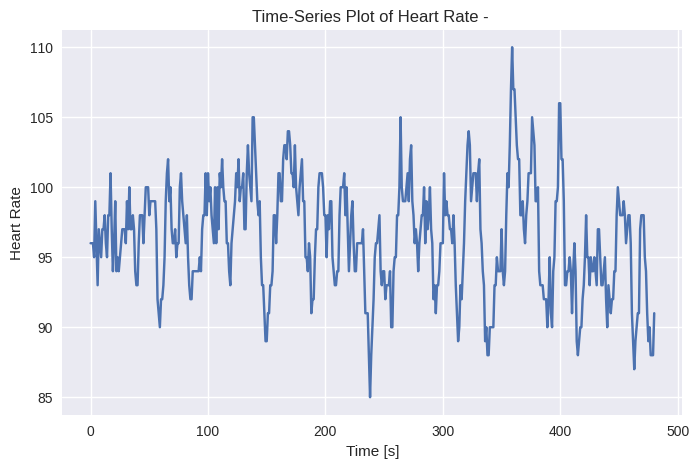

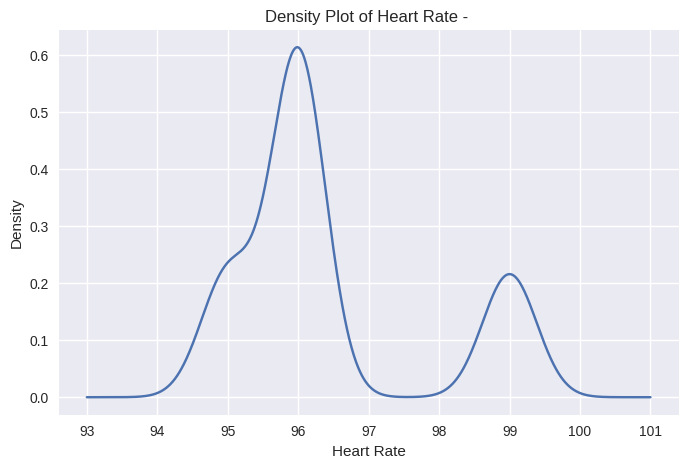

In [ ]:
# Select the 36th person's dataframe
person_df = merged_dfs[35]

# Set the figure size
plt.figure(figsize=(8, 5))
plt.plot(person_df['Time_S'].loc[:130000], person_df[' HR'].loc[:130000])
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate')
plt.title(f'Time-Series Plot of Heart Rate - ')
plt.grid(True)
plt.show()



plt.figure(figsize=(8, 5))
person_df[' HR'].loc[:600].plot(kind='density')
plt.xlabel('Heart Rate')
plt.title(f'Density Plot of Heart Rate - ')
plt.grid(True)
plt.show()


## Feature engineering

In [ ]:
print